# packages and data download

In [ ]:
!pip install pytorch-lightning wandb interpret

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 812.3/812.3 kB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 67.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 65.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.2/300.2 kB 38.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (

In [ ]:
# get max audio len from wavs in directory AudioWAV/
import os
from os import listdir
from os.path import isfile, join

import torch
import torchaudio
import librosa
from transformers import Wav2Vec2Processor, Wav2Vec2Model
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
import numpy as np
import pandas as pd
import pytorch_lightning as pl
from torch import nn, optim
import wandb
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from tqdm import tqdm
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show
import matplotlib.pyplot as plt
from statistics import median

In [ ]:
import random
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    # If you are using GPUs, you should also set the seed for all the GPUs.
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)

set_seed(42)

# Load data (split ready)

In [ ]:
train_df = pd.read_csv('data/crema_train_df.csv')
test_df = pd.read_csv('data/crema_test_df.csv')
val_df = pd.read_csv('data/crema_val_df.csv')

# Dataset

In [ ]:
class CustomAudioDataset(Dataset):
    def __init__(self, file_paths, labels_metainfo, max_len, target='emotion_label', processor_name="facebook/wav2vec2-large-960h-lv60-self", sampling_rate=16000, fp16=True):
        self.file_paths = file_paths
        self.labels = list(labels_metainfo[target])
        self.max_len = max_len
        self.sampling_rate = sampling_rate
        self.processor = Wav2Vec2Processor.from_pretrained(processor_name)
        self.fp16 = fp16

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        # Load audio file using librosa
        audio, sr = librosa.load(self.file_paths[idx], sr=self.sampling_rate)
        audio = torch.from_numpy(audio).float()

        # Pad/Truncate the audio to max_len
        if audio.shape[0] > self.max_len:
            audio = audio[:self.max_len]
        else:
            pad_len = self.max_len - audio.shape[0]
            audio = torch.nn.functional.pad(audio, (0, pad_len))

        # Use processor to preprocess the audio
        inputs = self.processor(audio, sampling_rate=self.sampling_rate, return_tensors="pt", padding=True)
        input_values = inputs.input_values.squeeze(0)  # Remove batch dimension
        if self.fp16:
          input_values = input_values.to(torch.float16)

        # Get the corresponding label
        label = self.labels[idx]

        return input_values, label

# Model

In [ ]:
class AudioClassifier(nn.Module):
    def __init__(self, config):
        super(AudioClassifier, self).__init__()
        self.config = config
        if config['fp16']:
          self.body = Wav2Vec2Model.from_pretrained(config['model_name'], torch_dtype=torch.float16)
        else:
          self.body = Wav2Vec2Model.from_pretrained(config['model_name'])
        if self.config['freeze_cnn']:
            for param in self.body.feature_extractor.parameters():
                param.requires_grad = False
        self.avg_pool = nn.AvgPool1d(kernel_size=config['in_seq_len'])
        self.classifier = nn.Sequential(
            nn.Linear(config['in_dim'], config['hidden_dim']),
            nn.LeakyReLU(),
            nn.BatchNorm1d(config['hidden_dim']),
            nn.Dropout(p=config['dropout']),
            nn.Linear(config['hidden_dim'], config['num_classes']),
        )


    def forward(self, x):
        x = self.body(x).last_hidden_state
        x = x.permute(0, 2, 1)
        x = self.avg_pool(x)
        x = x.squeeze(2)
        x = self.classifier(x)
        return x


class ClassifierModel(pl.LightningModule):
    def __init__(self, config):
        super(ClassifierModel, self).__init__()
        self.config = config
        self.model = AudioClassifier(config)

        if self.config['kaiming_init']:
            self.model.classifier.apply(self.init_weights)

        self.criterion = nn.CrossEntropyLoss()
        self.learning_rate = config['learning_rate']
        self.batch_size = config['batch_size']
        self.val_progress = []
        self.train_progress = []
        self.test_progress = []
        self.val_loss = 0.0
        self.train_loss = 0.0
        self.best_acc = 0
        self.best_f1 = 0
        self.best_epoch = 0

    def configure_optimizers(self):
        # initialize Adam optimizer and scheduler with warmup
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate, weight_decay=self.config['weight_decay'])
        if self.config['scheduler'] == 'cycle':
            self.scheduler = optim.lr_scheduler.CyclicLR(self.optimizer, base_lr=self.config['min_lr'], max_lr=self.config['max_lr'], step_size_up=self.config['step_size'], cycle_momentum=False)
            return [self.optimizer], [self.scheduler]
        elif self.config['scheduler'] == 'step':
            self.scheduler = optim.lr_scheduler.StepLR(self.optimizer, step_size=self.config['step_size'], gamma=self.config['gamma'])
        else:
            return [self.optimizer]


    def forward(self, x):
        return self.model(x)


    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.kaiming_uniform_(m.weight, nonlinearity=self.config['init_nonlinearity'])
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)

    def training_step(self, batch, batch_idx):
        x, y = batch
        probs = self(x)
        if self.config['fp16']:
          probs = probs.float()
        loss = self.criterion(probs, y)
        self.train_loss += loss.item()
        self.log('train_loss', loss)
        probs = nn.functional.softmax(probs, dim=1)
        self.train_progress.append((probs, y))
        return loss


    def validation_step(self, batch, batch_idx):
        x, y = batch
        probs = self(x)
        if self.config['fp16']:
          probs = probs.float()
        loss = self.criterion(probs, y)
        self.val_loss += loss.item()
        self.log('val_loss', loss)
        # save predictions and true labels to calculate accuracy on full validation after epoch end
        probs = nn.functional.softmax(probs, dim=1)
        self.val_progress.append((probs, y))
        return loss

    def on_validation_epoch_end(self):
        # calculate accuracy on full validation set
        preds = torch.cat([pred for pred, y in self.val_progress], dim=0)
        y = torch.cat([y for pred, y in self.val_progress], dim=0)
        preds = torch.argmax(preds, dim=1)
        acc = accuracy_score(y.cpu(), preds.cpu())
        precision, recall, f1, _ = precision_recall_fscore_support(y.cpu(), preds.cpu(), average='macro')

        if len(self.train_progress) > 0:
            train_preds = torch.cat([pred for pred, y in self.train_progress], dim=0)
            train_y = torch.cat([y for pred, y in self.train_progress], dim=0)
            train_preds = torch.argmax(train_preds, dim=1)
            train_acc = accuracy_score(train_y.cpu(), train_preds.cpu())
        else:
            train_acc = 0.0

        # log metrics based on configuration settings
        if self.config['log'] in ['wandb', 'all']:
            log_dict = {'train_loss': self.train_loss, 'train acc': train_acc, 'val_loss': self.val_loss, 'val_acc': acc, 'val_precision': precision, 'val_recall': recall, 'val_f1': f1}
            if self.config['scheduler'] == 'step':
                log_dict['lr'] = self.scheduler.get_last_lr()[0]
            wandb.log(log_dict)
        if self.config['log'] in ['stdout', 'all']:
            print(f'Training loss: {self.train_loss}')
            print(f'Validation accuracy: {acc}')
            print(f'Validation loss: {self.val_loss}')
            print(f'Validation precision: {precision}')
            print(f'Validation recall: {recall}')
            print(f'Validation f1: {f1}')
            if self.config['scheduler'] == 'step':
                print(f'Learning rate: {self.scheduler.get_last_lr()[0]}')

        # saved best model, based on chosen target metric if save_best is set to True
        if self.config['save_best']:
            if self.config['target_metric'] == 'accuracy' and acc >= self.best_acc:
                self.best_acc = acc
                self.save_checkpoint('/content/weights/'+self.config['run_name']+'.pth')
                self.best_epoch = self.current_epoch
                self.best_f1 = f1
            elif self.config['target_metric'] == 'f1' and f1 >= self.best_f1:
                self.best_f1 = f1
                self.save_checkpoint('/content/weights/'+self.config['run_name']+'.pth')
                self.best_epoch = self.current_epoch
                self.best_acc = acc

        # reset variables for next epoch
        self.val_progress = []
        self.val_loss = 0.0
        self.train_loss = 0.0
        self.train_progress = []


    def test_step(self, batch, batch_idx):
        x, y = batch
        probs = self(x)
        if self.config['fp16']:
          probs = probs.float()
        loss = self.criterion(probs, y)
        self.log('test_loss', loss)
        probs = nn.functional.softmax(probs, dim=1)
        self.test_progress.append((probs, y))
        return loss

    def on_test_epoch_end(self):
        # calculate accuracy on full test set
        preds = torch.cat([pred for pred, y in self.test_progress], dim=0)
        y = torch.cat([y for pred, y in self.test_progress], dim=0)
        preds = torch.argmax(preds, dim=1)
        acc = accuracy_score(y.cpu(), preds.cpu())
        precision, recall, f1, _ = precision_recall_fscore_support(y.cpu(), preds.cpu(), average='macro')

        # log metrics based on configuration settings
        if self.config['log'] in ['wandb', 'all']:
            wandb.log({'test_acc': acc, 'test_precision': precision, 'test_recall': recall, 'test_f1': f1})
        if self.config['log'] in ['stdout', 'all']:
            print(f'Test accuracy: {acc}')
            print(f'Test precision: {precision}')
            print(f'Test recall: {recall}')
            print(f'Test f1: {f1}')

        # reset variables for next epoch
        self.test_progress = []


    def save_checkpoint(self, path):
        """
        Saves a checkpoint, optimizer, and scheduler from a specified path.
        :param path: The file path from which to load the checkpoint.
        """
        model_state = {
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict()
        }
        if self.config['scheduler'] is not None:
            model_state['scheduler_state_dict'] = self.scheduler.state_dict()
        torch.save(model_state, path)

    def load_checkpoint(self, path):
        """
        Loads a checkpoint, optimizer, and scheduler from a specified path.
        :param path: The file path from which to load the checkpoint.
        """
        checkpoint = torch.load(path)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        if self.config['scheduler'] is not None:
            self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

def inference(model, dataloader, device):
    model.eval()  # Set the model to evaluation mode

    true_labels = []
    predictions = []
    soft_labels = []

    with torch.no_grad():  # Disable gradient calculation
        for inputs, labels in tqdm(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(inputs)

            # Get soft labels (probabilities)
            softmax_outputs = nn.functional.softmax(outputs, dim=1)
            soft_labels.extend(softmax_outputs.cpu().numpy())

            # Get predicted labels
            _, preds = torch.max(outputs, 1)
            predictions.extend(preds.cpu().numpy())

            # Save true labels
            true_labels.extend(labels.cpu().numpy())

    return true_labels, predictions, soft_labels


# misc processing

In [ ]:
emotions_label_encoder = {
    'angry' : 0,
    'disgust': 1,
    'fear': 2,
    'happy': 3,
    'neutral': 4,
    'sad': 5
}
emotions_label_decoder = {v: k for k, v in emotions_label_encoder.items()}

In [ ]:
max_len = 0

mypath = 'AudioWAV/'
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
for file in onlyfiles:
    audio, sr = librosa.load(mypath + file, sr=16000)
    if audio.shape[0] > max_len:
        max_len = audio.shape[0]

In [ ]:
train_df['emotion_label'] = train_df['emotion'].map(emotions_label_encoder)
test_df['emotion_label'] = test_df['emotion'].map(emotions_label_encoder)
val_df['emotion_label'] = val_df['emotion'].map(emotions_label_encoder)

# Experiment

In [ ]:
config = {
    "regressor_classifier": False,
    "processor_name": "audeering/wav2vec2-large-robust-12-ft-emotion-msp-dim",
    "model_name": "audeering/wav2vec2-large-robust-12-ft-emotion-msp-dim",
    "sampling_rate": 16000,
    'batch_size': 32,
    'learning_rate': 0.00003,
    'kaiming_init': False,
    'init_nonlinearity': 'leaky_relu',
    'freeze_cnn': True,
    'in_seq_len': 250,
    'in_dim': 1024,
    'hidden_dim': 512,
    'num_classes': 6,
    'fp16': False,
    'wandb_api_key': '<wandb_key>',
    'scheduler': None,
    'log': 'wandb',
    'save_best': True,
    'target_metric': 'accuracy',
    'dropout': 0.4,
    'weight_decay': 0.001,
    'epochs': 10
}

In [ ]:
wandb.init(project='audio-emotion-classification', config=config)
wandb.login(key = config['wandb_api_key'])
config['run_name'] = wandb.run.name

wandb: Currently logged in as: timothy-senchenko. Use `wandb login --relogin` to force relogin


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


In [ ]:
train_set = CustomAudioDataset(list(train_df['path']), train_df.drop('path', axis=1), max_len, processor_name=config['processor_name'], fp16=config['fp16'])
val_set = CustomAudioDataset(list(val_df['path']), val_df.drop('path', axis=1), max_len, processor_name=config['processor_name'], fp16=config['fp16'])
test_set = CustomAudioDataset(list(test_df['path']), test_df.drop('path', axis=1), max_len, processor_name=config['processor_name'], fp16=config['fp16'])

# Create DataLoader
trainloader = torch.utils.data.DataLoader(train_set, batch_size=config['batch_size'], shuffle=True)
valloader = torch.utils.data.DataLoader(val_set, batch_size=config['batch_size'], shuffle=False)
testloader = torch.utils.data.DataLoader(test_set, batch_size=config['batch_size'], shuffle=False)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when poss

In [ ]:
cls = ClassifierModel(config)
if config['fp16']:
  cls = cls.to(torch.float16)

Some weights of Wav2Vec2Model were not initialized from the model checkpoint at audeering/wav2vec2-large-robust-12-ft-emotion-msp-dim and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
if config['fp16']:
  trainer = pl.Trainer(max_epochs=config['epochs'], check_val_every_n_epoch=1, precision='16-true')
else:
  trainer = pl.Trainer(max_epochs=config['epochs'], check_val_every_n_epoch=1)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(cls, trainloader, valloader)

# fit EBM

## Make BB predictions and save soft labels

In [ ]:
cls = ClassifierModel(config).to('cuda')
cls.configure_optimizers()
cls.load_checkpoint('weights/crema_weights/winter-gorge-66.pth')

In [ ]:
train_set = CustomAudioDataset(list(train_df['path']), train_df.drop('path', axis=1), max_len, processor_name=config['processor_name'], fp16=config['fp16'])
val_set = CustomAudioDataset(list(val_df['path']), val_df.drop('path', axis=1), max_len, processor_name=config['processor_name'], fp16=config['fp16'])
test_set = CustomAudioDataset(list(test_df['path']), test_df.drop('path', axis=1), max_len, processor_name=config['processor_name'], fp16=config['fp16'])

trainloader = torch.utils.data.DataLoader(train_set, batch_size=config['batch_size'], shuffle=False)
valloader = torch.utils.data.DataLoader(val_set, batch_size=config['batch_size'], shuffle=False)
testloader = torch.utils.data.DataLoader(test_set, batch_size=config['batch_size'], shuffle=False)

In [ ]:
train_labels, train_preds, train_soft_labels = inference(cls, trainloader, 'cuda')
val_labels, val_preds, val_soft_labels = inference(cls, valloader, 'cuda')
test_labels, test_preds, test_soft_labels = inference(cls, testloader, 'cuda')

100%|██████████| 36/36 [00:40<00:00,  1.11s/it]


In [ ]:
acc = accuracy_score(test_labels, test_preds)
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, test_preds, average='macro')

print("BB metrics:")
print(f'Test accuracy: {acc}')
print(f'Test precision: {precision}')
print(f'Test recall: {recall}')
print(f'Test f1: {f1}')

BB metrics:
Test accuracy: 0.7288578901482128
Test precision: 0.744050791455109
Test recall: 0.7265367224734205
Test f1: 0.7274605830904363


## train ebm on BB predictions with opensmile features

In [ ]:
cream_opensmile = pd.read_csv('data/crema_opensmile_avd.csv')
cream_opensmile['path'] = cream_opensmile['path'].apply(lambda x: x[2:])

train_ebm = train_df.merge(cream_opensmile, on='path')
val_ebm = val_df.merge(cream_opensmile, on='path')
test_ebm = test_df.merge(cream_opensmile, on='path')
crema_test_gt = np.array(test_ebm['emotion_x'])

protected_attrs = ['ActorID_x', 'ActorID_y', 'emotion_x', 'emotion_y', 'path', 'arousal', 'valence', 'dominance', 'Age', 'Sex', 'Race', 'Ethnicity', 'sentence', 'intensity', 'emotion_label']

train_ebm = train_ebm.drop(protected_attrs, axis=1)
test_ebm = test_ebm.drop(protected_attrs, axis=1)
val_ebm = val_ebm.drop(protected_attrs, axis=1)

In [ ]:
train_val = pd.concat([train_ebm, val_ebm])
true_and_preds = train_labels.copy()
true_and_preds.extend(val_preds)

preds_and_preds = train_preds.copy()
preds_and_preds.extend(val_preds)

ebm_crema = ExplainableBoostingClassifier()
ebm_crema.fit(train_val, preds_and_preds)

/usr/local/lib/python3.10/dist-packages/interpret/glassbox/_ebm/_ebm.py:999: UserWarning: Detected multiclass problem. Forcing interactions to 0. Multiclass interactions only have local explanations. They are not currently displayed in the global explanation visualizations. Set interactions=0 to disable this warning. If you still want multiclass interactions, this API accepts a list, and the measure_interactions function can be used to detect them.
  warn(


ExplainableBoostingClassifier()

In [ ]:
ebm_test_pred = ebm_crema.predict(test_ebm)

In [ ]:
# for saving the predictions for BB and its global surrogate model

cremad_opensmile_train = train_ebm.copy()
cremad_opensmile_train['true_emotion_label'] = train_labels
cremad_opensmile_train['bb_pred_emotion_label'] = train_preds

cremad_opensmile_val = val_ebm.copy()
cremad_opensmile_val['true_emotion_label'] = val_labels
cremad_opensmile_val['bb_pred_emotion_label'] = val_preds

cremad_opensmile_test = test_ebm.copy()
cremad_opensmile_test['true_emotion_label'] = test_labels
cremad_opensmile_test['bb_pred_emotion_label'] = test_preds
cremad_opensmile_test['gs_pred_emotion_label'] = ebm_test_pred

cremad_opensmile_train.to_csv('BB_and_EBM_predictions/cremad_opensmile_train.csv', index=False)
cremad_opensmile_val.to_csv('BB_and_EBM_predictions/cremad_opensmile_val.csv', index=False)
cremad_opensmile_test.to_csv('BB_and_EBM_predictions/cremad_opensmile_test.csv', index=False)

In [ ]:
print('test fidelity :', accuracy_score(test_preds, ebm_test_pred))

test fidelity : 0.5457715780296426


In [ ]:
x_test_crema, ebm_test_pred_crema = test_ebm.copy(), ebm_test_pred.copy()

In [ ]:
ebm_global = ebm_crema.explain_global()
show(ebm_global)

# EmoDB

## Train BB

In [ ]:
train_df = pd.read_csv('data/emodb_train_df.csv')
test_df = pd.read_csv('data/emodb_test_df.csv')
val_df = pd.read_csv('data/emodb_val_df.csv')

In [ ]:
wandb.init(project='audio-emotion-classification', config=config)
wandb.login(key = config['wandb_api_key'])
config['run_name'] = wandb.run.name

In [ ]:
config = {
    "regressor_classifier": False,
    "processor_name": "audeering/wav2vec2-large-robust-12-ft-emotion-msp-dim",
    "model_name": "audeering/wav2vec2-large-robust-12-ft-emotion-msp-dim",
    "sampling_rate": 16000,
    'batch_size': 32,
    'learning_rate': 0.00005,
    'kaiming_init': False,
    'init_nonlinearity': 'leaky_relu',
    'freeze_cnn': True,
    'in_seq_len': 250,
    'in_dim': 1024,
    'hidden_dim': 512,
    'num_classes': 6,
    'fp16': False,
    'wandb_api_key': '<wandb_key>',
    'scheduler': None,
    'log': 'wandb',
    'save_best': True,
    'target_metric': 'accuracy',
    'dropout': 0.4,
    'weight_decay': 0.001,
    'epochs': 10
}

In [ ]:
wandb.init(project='audio-emotion-classification-emodb', config=config)
wandb.login(key = config['wandb_api_key'])
config['run_name'] = wandb.run.name

In [ ]:
train_set = CustomAudioDataset(list(train_df['path']), train_df.drop('path', axis=1), max_len, processor_name=config['processor_name'], fp16=config['fp16'])
val_set = CustomAudioDataset(list(val_df['path']), val_df.drop('path', axis=1), max_len, processor_name=config['processor_name'], fp16=config['fp16'])
test_set = CustomAudioDataset(list(test_df['path']), test_df.drop('path', axis=1), max_len, processor_name=config['processor_name'], fp16=config['fp16'])

# Create DataLoader
trainloader = torch.utils.data.DataLoader(train_set, batch_size=config['batch_size'], shuffle=True)
valloader = torch.utils.data.DataLoader(val_set, batch_size=config['batch_size'], shuffle=False)
testloader = torch.utils.data.DataLoader(test_set, batch_size=config['batch_size'], shuffle=False)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



In [ ]:
cls = ClassifierModel(config)

Some weights of Wav2Vec2Model were not initialized from the model checkpoint at audeering/wav2vec2-large-robust-12-ft-emotion-msp-dim and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
trainer = pl.Trainer(max_epochs=config['epochs'], check_val_every_n_epoch=1)

In [ ]:
trainer.fit(cls, trainloader, valloader)

## predict BB

In [ ]:
cls = ClassifierModel(config).to('cuda')
cls.configure_optimizers()

Some weights of Wav2Vec2Model were not initialized from the model checkpoint at audeering/wav2vec2-large-robust-12-ft-emotion-msp-dim and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     capturable: False
     differentiable: False
     eps: 1e-08
     foreach: None
     fused: None
     lr: 5e-05
     maximize: False
     weight_decay: 0.001
 )]

In [ ]:
cls.load_checkpoint('weights/emodb_weights/leafy-water-1.pth')

In [ ]:
train_set = CustomAudioDataset(list(train_df['path']), train_df.drop('path', axis=1), max_len, processor_name=config['processor_name'], fp16=config['fp16'])
val_set = CustomAudioDataset(list(val_df['path']), val_df.drop('path', axis=1), max_len, processor_name=config['processor_name'], fp16=config['fp16'])
test_set = CustomAudioDataset(list(test_df['path']), test_df.drop('path', axis=1), max_len, processor_name=config['processor_name'], fp16=config['fp16'])

trainloader = torch.utils.data.DataLoader(train_set, batch_size=config['batch_size'], shuffle=False)
valloader = torch.utils.data.DataLoader(val_set, batch_size=config['batch_size'], shuffle=False)
testloader = torch.utils.data.DataLoader(test_set, batch_size=config['batch_size'], shuffle=False)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



In [ ]:
train_labels, train_preds, train_soft_labels = inference(cls, trainloader, 'cuda')
val_labels, val_preds, val_soft_labels = inference(cls, valloader, 'cuda')
test_labels, test_preds, test_soft_labels = inference(cls, testloader, 'cuda')

100%|██████████| 2/2 [00:01<00:00,  1.27it/s]


In [ ]:
acc = accuracy_score(test_labels, test_preds)
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, test_preds, average='macro')

print("BB metrics:")
print(f'Test accuracy: {acc}')
print(f'Test precision: {precision}')
print(f'Test recall: {recall}')
print(f'Test f1: {f1}')

BB metrics:
Test accuracy: 0.9361702127659575
Test precision: 0.9439814814814814
Test recall: 0.8833333333333333
Test f1: 0.8982456140350877


## EBM training and FI

In [ ]:
protected_attrs = ['Unnamed: 0', 'SpeakerID', 'Emotion', 'Path', 'path', 'Filename', 'Age', 'Sex', 'emotion_label']

train_ebm = train_df.drop(protected_attrs, axis=1)
test_ebm = test_df.drop(protected_attrs, axis=1)
val_ebm = val_df.drop(protected_attrs, axis=1)

In [ ]:
train_val = pd.concat([train_ebm, val_ebm])
true_and_preds = train_labels.copy()
true_and_preds.extend(val_preds)

preds_and_preds = train_preds.copy()
preds_and_preds.extend(val_preds)

ebm_emodb = ExplainableBoostingClassifier()
ebm_emodb.fit(train_val, preds_and_preds)

/usr/local/lib/python3.10/dist-packages/interpret/glassbox/_ebm/_ebm.py:999: UserWarning:

Detected multiclass problem. Forcing interactions to 0. Multiclass interactions only have local explanations. They are not currently displayed in the global explanation visualizations. Set interactions=0 to disable this warning. If you still want multiclass interactions, this API accepts a list, and the measure_interactions function can be used to detect them.



ExplainableBoostingClassifier()

In [ ]:
ebm_test_pred = ebm_emodb.predict(test_ebm)

In [ ]:
print('EmoDB test fidelity :', accuracy_score(test_preds, ebm_test_pred))

EmoDB test fidelity : 0.7446808510638298


In [ ]:
x_test_emodb, ebm_test_pred_emodb = test_ebm.copy(), ebm_test_pred.copy()

In [ ]:
ebm_global = ebm_emodb.explain_global()
show(ebm_global)

In [ ]:
# for saving the predictions for BB and its global surrogate model
emodb_opensmile_train = train_ebm.copy()
emodb_opensmile_train['true_emotion_label'] = train_labels
emodb_opensmile_train['bb_pred_emotion_label'] = train_preds

emodb_opensmile_val = val_ebm.copy()
emodb_opensmile_val['true_emotion_label'] = val_labels
emodb_opensmile_val['bb_pred_emotion_label'] = val_preds

emodb_opensmile_test = test_ebm.copy()
emodb_opensmile_test['true_emotion_label'] = test_labels
emodb_opensmile_test['bb_pred_emotion_label'] = test_preds
emodb_opensmile_test['gs_pred_emotion_label'] = ebm_test_pred

emodb_opensmile_train.to_csv('BB_and_EBM_predictions/emodb_opensmile_train.csv', index=False)
emodb_opensmile_val.to_csv('BB_and_EBM_predictions/emodb_opensmile_val.csv', index=False)
emodb_opensmile_test.to_csv('BB_and_EBM_predictions/emodb_opensmile_test.csv', index=False)

# BanglSER

## Train BB

### Load ready data

In [ ]:
train_df = pd.read_csv('data/beasc_train_df.csv')
test_df = pd.read_csv('data/beasc_test_df.csv')
val_df = pd.read_csv('data/beasc_val_df.csv')

### Train

In [ ]:
config = {
    "regressor_classifier": False,
    "processor_name": "audeering/wav2vec2-large-robust-12-ft-emotion-msp-dim",
    "model_name": "audeering/wav2vec2-large-robust-12-ft-emotion-msp-dim",
    "sampling_rate": 16000,
    'batch_size': 32,
    'learning_rate': 0.00003,
    'kaiming_init': False,
    'init_nonlinearity': 'leaky_relu',
    'freeze_cnn': True,
    'in_seq_len': 250,
    'in_dim': 1024,
    'hidden_dim': 512,
    'num_classes': 6,
    'fp16': False,
    'wandb_api_key': '<wandb_key>',
    'scheduler': None,
    'log': 'wandb',
    'save_best': True,
    'target_metric': 'accuracy',
    'dropout': 0.4,
    'weight_decay': 0.001,
    'epochs': 10
}

In [ ]:
wandb.init(project='audio-emotion-classification-BanglaSER', config=config)
wandb.login(key = config['wandb_api_key'])
config['run_name'] = wandb.run.name

train acc,▁▅▇████
train_loss,▁█▄▂▂▂▁
val_acc,▁▇█▇███
val_f1,▁▆▆▇▇██
val_loss,▂█▆▃▂▂▁
val_precision,▁▆▆████
val_recall,▁▆▆▇███
train acc,1.0
train_loss,1.39043
val_acc,0.87654
val_f1,0.8749


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


In [ ]:
train_set = CustomAudioDataset(list(train_df['path']), train_df.drop('path', axis=1), max_len, processor_name=config['processor_name'], fp16=config['fp16'])
val_set = CustomAudioDataset(list(val_df['path']), val_df.drop('path', axis=1), max_len, processor_name=config['processor_name'], fp16=config['fp16'])
test_set = CustomAudioDataset(list(test_df['path']), test_df.drop('path', axis=1), max_len, processor_name=config['processor_name'], fp16=config['fp16'])

# Create DataLoader
trainloader = torch.utils.data.DataLoader(train_set, batch_size=config['batch_size'], shuffle=True)
valloader = torch.utils.data.DataLoader(val_set, batch_size=config['batch_size'], shuffle=False)
testloader = torch.utils.data.DataLoader(test_set, batch_size=config['batch_size'], shuffle=False)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



In [ ]:
cls = ClassifierModel(config)

Some weights of Wav2Vec2Model were not initialized from the model checkpoint at audeering/wav2vec2-large-robust-12-ft-emotion-msp-dim and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
trainer = pl.Trainer(max_epochs=config['epochs'], check_val_every_n_epoch=1)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(cls, trainloader, valloader)

## Predict BB

In [ ]:
cls = ClassifierModel(config).to('cuda')
cls.configure_optimizers()

Some weights of Wav2Vec2Model were not initialized from the model checkpoint at audeering/wav2vec2-large-robust-12-ft-emotion-msp-dim and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     capturable: False
     differentiable: False
     eps: 1e-08
     foreach: None
     fused: None
     lr: 3e-05
     maximize: False
     weight_decay: 0.001
 )]

In [ ]:
cls.load_checkpoint('weights/banglaser_weights/generous-pyramid-5.pth')

In [ ]:
train_set = CustomAudioDataset(list(train_df['path']), train_df.drop('path', axis=1), max_len, processor_name=config['processor_name'], fp16=config['fp16'])
val_set = CustomAudioDataset(list(val_df['path']), val_df.drop('path', axis=1), max_len, processor_name=config['processor_name'], fp16=config['fp16'])
test_set = CustomAudioDataset(list(test_df['path']), test_df.drop('path', axis=1), max_len, processor_name=config['processor_name'], fp16=config['fp16'])

trainloader = torch.utils.data.DataLoader(train_set, batch_size=config['batch_size'], shuffle=False)
valloader = torch.utils.data.DataLoader(val_set, batch_size=config['batch_size'], shuffle=False)
testloader = torch.utils.data.DataLoader(test_set, batch_size=config['batch_size'], shuffle=False)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



In [ ]:
train_labels, train_preds, train_soft_labels = inference(cls, trainloader, 'cuda')
val_labels, val_preds, val_soft_labels = inference(cls, valloader, 'cuda')
test_labels, test_preds, test_soft_labels = inference(cls, testloader, 'cuda')

100%|██████████| 5/5 [00:08<00:00,  1.66s/it]


In [ ]:
acc = accuracy_score(test_labels, test_preds)
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, test_preds, average='macro')

print("BB metrics:")
print(f'Test accuracy: {acc}')
print(f'Test precision: {precision}')
print(f'Test recall: {recall}')
print(f'Test f1: {f1}')

BB metrics:
Test accuracy: 0.8518518518518519
Test precision: 0.8553119867723985
Test recall: 0.8518518518518517
Test f1: 0.8517735494479681


## EBM training and FI

In [ ]:
protected_attrs = ['Unnamed: 0.1', 'Unnamed: 0', 'ActorID', 'Emotion', 'Path', 'path', 'arousal', 'valence', 'dominance','Gender', 'emotion_label']

train_bser = train_df.drop(protected_attrs, axis=1)
test_bser = test_df.drop(protected_attrs, axis=1)
val_bser = val_df.drop(protected_attrs, axis=1)

In [ ]:
train_val = pd.concat([train_bser, val_bser])
true_and_preds = train_labels.copy()
true_and_preds.extend(val_preds)

preds_and_preds = train_preds.copy()
preds_and_preds.extend(val_preds)

ebm_banglaser = ExplainableBoostingClassifier()
ebm_banglaser.fit(train_val, preds_and_preds)

/usr/local/lib/python3.10/dist-packages/interpret/glassbox/_ebm/_ebm.py:999: UserWarning:

Detected multiclass problem. Forcing interactions to 0. Multiclass interactions only have local explanations. They are not currently displayed in the global explanation visualizations. Set interactions=0 to disable this warning. If you still want multiclass interactions, this API accepts a list, and the measure_interactions function can be used to detect them.



ExplainableBoostingClassifier()

In [ ]:
ebm_test_pred = ebm_banglaser.predict(test_bser)

In [ ]:
print('BanglaSER test fidelity :', accuracy_score(test_preds, ebm_test_pred))

BanglaSER test fidelity : 0.7851851851851852


In [ ]:
x_test_banglaser, ebm_test_pred_banglaser = test_bser.copy(), ebm_test_pred.copy()

In [ ]:
ebm_global = ebm_banglaser.explain_global()
show(ebm_global)

In [ ]:
# for saving the predictions for BB and its global surrogate model
banglaser_opensmile_train = train_bser.copy()
banglaser_opensmile_train['true_emotion_label'] = train_labels
banglaser_opensmile_train['bb_pred_emotion_label'] = train_preds

banglaser_opensmile_val = val_bser.copy()
banglaser_opensmile_val['true_emotion_label'] = val_labels
banglaser_opensmile_val['bb_pred_emotion_label'] = val_preds

banglaser_opensmile_test = test_bser.copy()
banglaser_opensmile_test['true_emotion_label'] = test_labels
banglaser_opensmile_test['bb_pred_emotion_label'] = test_preds
banglaser_opensmile_test['gs_pred_emotion_label'] = ebm_test_pred

banglaser_opensmile_train.to_csv('BB_and_EBM_predictions/banglaser_opensmile_train.csv', index=False)
banglaser_opensmile_val.to_csv('BB_and_EBM_predictions/banglaser_opensmile_val.csv', index=False)
banglaser_opensmile_test.to_csv('BB_and_EBM_predictions/banglaser_opensmile_test.csv', index=False)

# Plotting FI across datasets

## Plotting functions

In [ ]:
def plot_top_feature_scores(datasets, dataset_labels, colors, model_name, figsize=(20, 6), bar_height=0.4):
    """
    Plots sorted top 10 feature scores across multiple datasets, indicating the model used.
    Features are split into two categories:
    - 5 with similar scores
    - 5 with diverse scores but present in all datasets
    """
    # Create DataFrames for each dataset and calculate combined feature list
    dfs = [pd.DataFrame(data).set_index('names') for data in datasets]
    all_features = sorted(set.intersection(*(set(df.index) for df in dfs)))

    # Keep only features present in all datasets
    for i in range(len(dfs)):
        dfs[i] = dfs[i].loc[all_features].reset_index()

    # Calculate total importance and variance of each feature across all datasets
    total_scores = np.sum([df['scores'].values for df in dfs], axis=0)
    score_variances = np.nanvar([df['scores'].values for df in dfs], axis=0)

    # Create a DataFrame for sorting features by total importance and variance
    feature_stats = pd.DataFrame({
        'features': all_features,
        'total_scores': total_scores,
        'score_variance': score_variances
    })

    # Select top 10 features, then split based on variance
    similar_scores = feature_stats.sort_values(by='score_variance').head(5)
    diverse_scores = feature_stats.sort_values(by='score_variance').tail(5)

    # Ensure selected features are present in all datasets
    similar_scores = similar_scores[similar_scores['features'].isin(all_features)]
    diverse_scores = diverse_scores[diverse_scores['features'].isin(all_features)]

    # Plotting setup for two side-by-side plots
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)

    # Plotting similar scores
    plot_features(similar_scores, dfs, dataset_labels, colors, model_name, 'Top 5 Features with Similar Scores', axes[0], bar_height)

    # Plotting diverse scores
    plot_features(diverse_scores, dfs, dataset_labels, colors, model_name, 'Top 5 Features with Diverse Scores', axes[1], bar_height)

    plt.tight_layout(pad=2.0)
    plt.savefig(f'/content/{model_name}', bbox_inches="tight")
    plt.show()

def plot_features(selected_features, dfs, dataset_labels, colors, model_name, plot_title, ax, bar_height):
    """
    Helper function to plot selected features on a specific subplot ax.
    """
    # Sort each dataset based on the selected features and ensure features with highest total scores are at top
    sorted_features = selected_features.sort_values(by='total_scores', ascending=False)['features'].tolist()
    filtered_dfs = []
    for df in dfs:
        filtered_df = df[df['names'].isin(sorted_features)].set_index('names').reindex(sorted_features).reset_index()
        filtered_dfs.append(filtered_df)

    indices = np.arange(len(sorted_features))

    # Initialize the left alignment for stacked bars
    lefts = np.zeros(len(sorted_features))

    for i, df in enumerate(filtered_dfs):
        ax.barh(indices, df['scores'], bar_height, label=dataset_labels[i], color=colors[i], left=lefts)
        lefts += df['scores'].values  # Update lefts for the next stack

    ax.set_ylabel('Features')
    ax.set_xlabel('Scores')
    ax.set_title(f'{plot_title} for {model_name}')
    ax.set_yticks(indices)
    ax.invert_yaxis()  # Most contributed on top
    ax.set_yticklabels(sorted_features)
    ax.legend()

def explain_angry_samples(ebm, X, y, pred):
    # Filter samples where y == pred == 'angry'
    angry_samples = X[(y == 'angry') & (pred == 'angry')]
    angry_indices = angry_samples.index

    # Generate local explanations for each 'angry' sample
    local_explanations = []
    for index in angry_indices:
        ebm_local = ebm.explain_local(X.loc[[index]], y[index])
        local_explanations.append(ebm_local.data(0))  # Store the local explanation data

    return local_explanations

def get_median_feature_contributions(local_explanations, top=5):
    # Collect feature contributions for each sample
    feature_contributions = {}
    for explanation in local_explanations:
        feature_names = explanation['names']
        feature_scores = explanation['scores']
        for name, score in zip(feature_names, feature_scores):
            if name not in feature_contributions:
                feature_contributions[name] = []
            feature_contributions[name].append(float(score[0]) if isinstance(score, np.ndarray) else float(score))

    # Calculate median contributions for each feature
    median_contributions = {name: median(scores) for name, scores in feature_contributions.items()}

    # Sort features by median contribution and select the top 5
    sorted_features = sorted(median_contributions.items(), key=lambda item: abs(item[1]), reverse=True)
    top_n_features = sorted_features[:top]

    # Print the top 5 features
    print(f"Top {top} Strongest Features Contributing to 'Angry' Class:")
    for feature, contribution in top_n_features:
        print(f"Feature: {feature}, Median Contribution: {contribution}")

    return top_n_features

## Plot strong features

In [ ]:
ebm_crema_global = ebm_crema.explain_global().data()
ebm_emodb_global = ebm_emodb.explain_global().data()
ebm_banglaser_global = ebm_banglaser.explain_global().data()

In [ ]:
datasets = [ebm_crema_global, ebm_banglaser_global, ebm_emodb_global]

In [ ]:
dataset_labels = ['CREMAD', 'BanglaSER', 'EMODB']

In [ ]:
colors = ['blue', 'green', 'red']

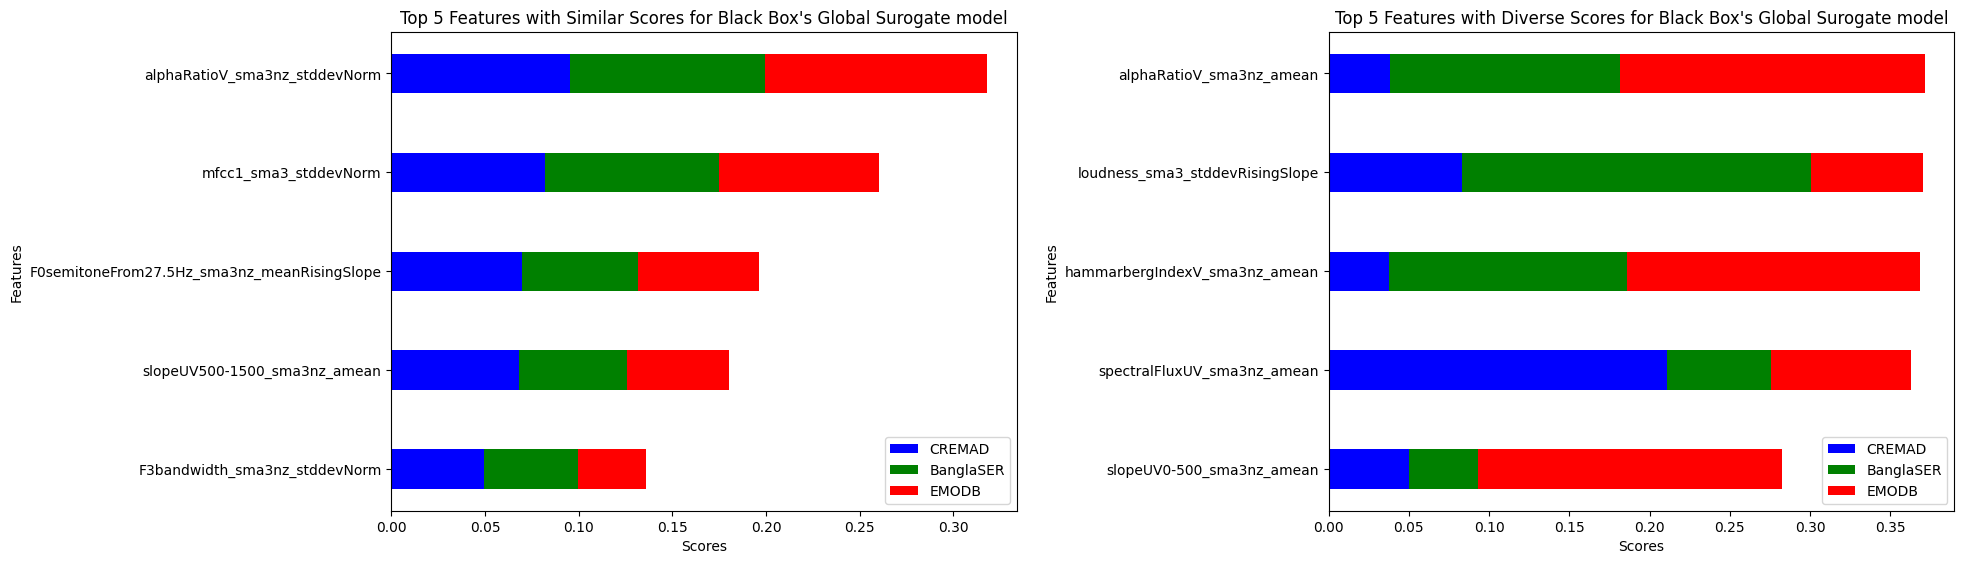

In [ ]:
model_name = "Black Box's Global Surogate model"
plot_top_feature_scores(datasets, dataset_labels, colors, model_name)

## Top 5 features plots

In [ ]:
def return_top_n_feature_importances(ebm, n=5):
    # Get the global explanation
    ebm_global = ebm.explain_global()

    # Access feature importances and names
    feature_importances = ebm_global.data()['scores']
    feature_names = ebm_global.data()['names']

    # Create a list of (name, importance) tuples
    features = list(zip(feature_names, feature_importances))

    # Sort features by importance in descending order and get the top 10
    top_n_features = sorted(features, key=lambda x: x[1], reverse=True)[:n]
    return top_n_features


def plot_top_n_feature_importances(top_n_features, font_size=12, dataset=''):
    # Separate names and importances for plotting
    names, importances = zip(*top_n_features)

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(names)), importances, align='center', color='skyblue')
    plt.yticks(range(len(names)), names, fontsize=font_size)
    plt.xlabel('Importance', fontsize=font_size)
    plt.ylabel('Features', fontsize=font_size)
    plt.title(f'{dataset}. Top {len(names)} Feature Importances', fontsize=font_size + 2)
    plt.gca().invert_yaxis()  # Invert y-axis to have the highest importance at the top
    plt.tight_layout()
    plt.show()

Black Box (Global Surrogate)


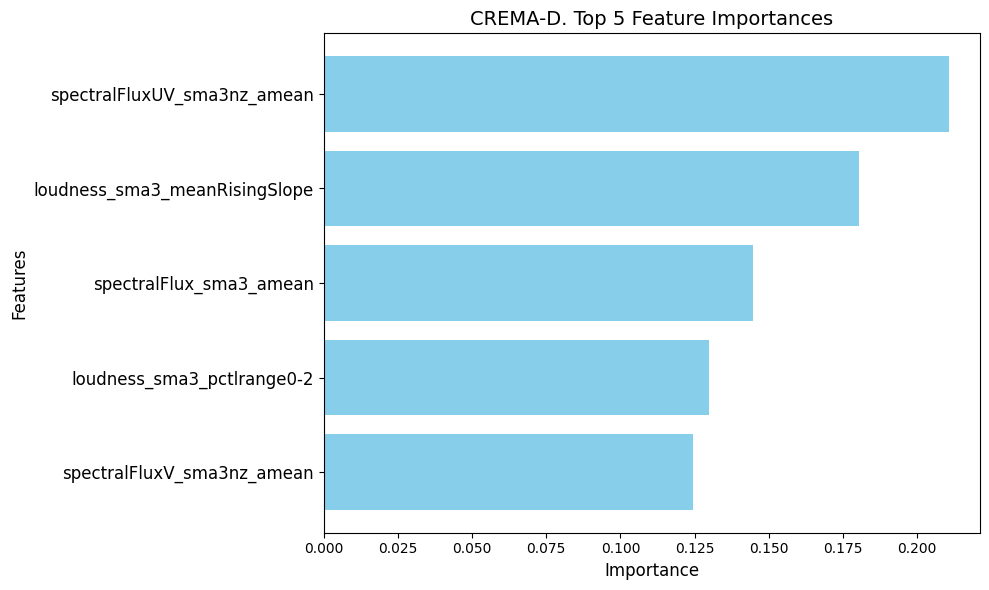

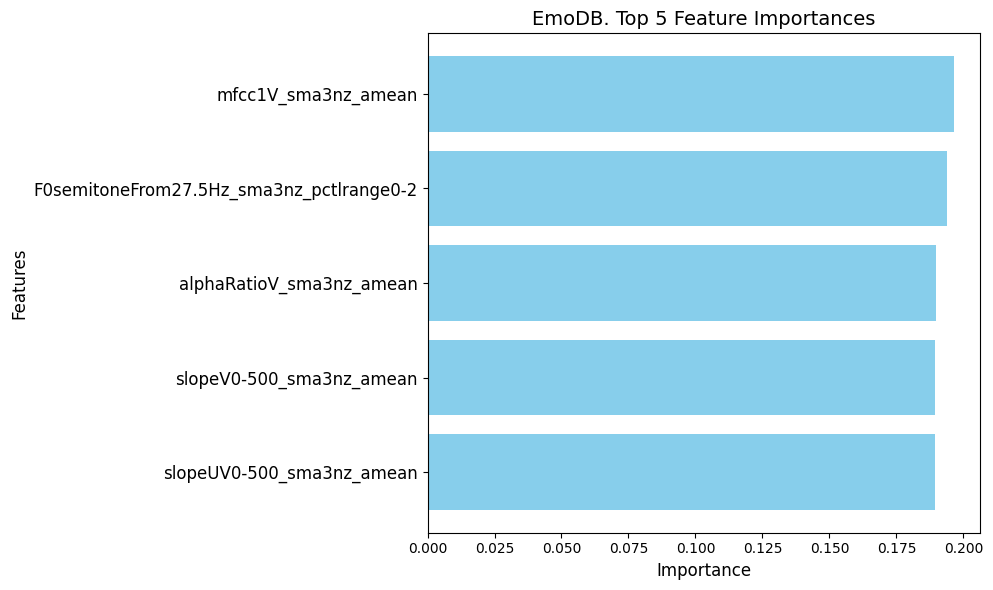

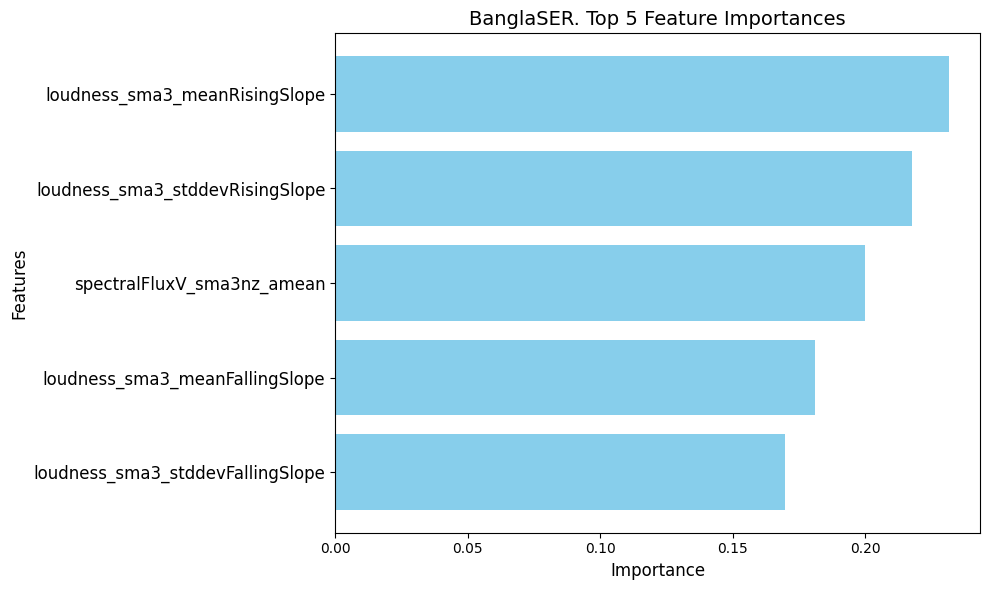

In [ ]:
print('Black Box (Global Surrogate)')
crema_fi = return_top_n_feature_importances(ebm_crema)
plot_top_n_feature_importances(crema_fi, dataset='CREMA-D')

emodb_fi = return_top_n_feature_importances(ebm_emodb)
plot_top_n_feature_importances(emodb_fi, dataset='EmoDB')

bangla_fi = return_top_n_feature_importances(ebm_banglaser)
plot_top_n_feature_importances(bangla_fi, dataset='BanglaSER')

In [ ]:
crema_fi

[('spectralFluxUV_sma3nz_amean', 0.21061238197213084),
 ('loudness_sma3_meanRisingSlope', 0.18054341927226986),
 ('spectralFlux_sma3_amean', 0.14470894446241533),
 ('loudness_sma3_pctlrange0-2', 0.12983457801485995),
 ('spectralFluxV_sma3nz_amean', 0.12454731228088517)]

In [ ]:
emodb_fi

[('mfcc1V_sma3nz_amean', 0.19639132484798236),
 ('F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2', 0.1937792020991983),
 ('alphaRatioV_sma3nz_amean', 0.18979462717951343),
 ('slopeV0-500_sma3nz_amean', 0.18948880305386803),
 ('slopeUV0-500_sma3nz_amean', 0.1894312472025049)]

In [ ]:
bangla_fi

[('loudness_sma3_meanRisingSlope', 0.23177748336144155),
 ('loudness_sma3_stddevRisingSlope', 0.2176462442018056),
 ('spectralFluxV_sma3nz_amean', 0.1997886885358462),
 ('loudness_sma3_meanFallingSlope', 0.18126446136985722),
 ('loudness_sma3_stddevFallingSlope', 0.16981580886663053)]

# Anrgy feature contribution

In [ ]:
from collections import defaultdict
from scipy.stats import mode

def get_local_explanations(ebm, x_test, y_test, y_pred, target_emotion):

    # Filter for instances where predicted label is 'angry'
    angry_indices = (y_pred == target_emotion)
    angry_x_test = x_test[angry_indices]
    angry_y_test = y_test[angry_indices]

    # Store local explanations
    local_explanations = []
    explanation_data = []

    # Iterate over each 'angry' instance to get local explanations
    for index, row in angry_x_test.iterrows():
        # Get local explanation for the specific instance
        local_explanation = ebm.explain_local(row.to_frame().transpose())
        local_explanations.append(local_explanation)

        # Access and store the raw explanation data for all visualizations
        explanation_details = local_explanation.data(-1)
        explanation_data.append(explanation_details)

    return local_explanations, explanation_data

# Helper function to build the contributions dictionary
def build_contributions_dict(explanation_data):
    contributions_dict = defaultdict(list)
    for explanation in explanation_data:
        for score, name in zip(explanation['specific'][0]['scores'], explanation['specific'][0]['names']):
            contributions_dict[name].append(score[0])
    return contributions_dict

# Calculate mean contributions
def calculate_mean_contributions(contributions_dict):
    return {name: np.mean(scores) for name, scores in contributions_dict.items()}

# Calculate median contributions
def calculate_median_contributions(contributions_dict):
    return {name: np.median(scores) for name, scores in contributions_dict.items()}

# Calculate mode contributions
def calculate_mode_contributions(contributions_dict):
    return {name: mode(scores)[0] for name, scores in contributions_dict.items()}


# Calculate mode contributions
def calculate_sum_contributions(contributions_dict):
    return {name: np.sum(scores) for name, scores in contributions_dict.items()}


def plot_top_5_features(dict1, dict2, dict3):
    # Function to extract the top 5 keys based on absolute values
    def get_top_5_features(d):
        return sorted(d.items(), key=lambda x: x[1], reverse=True)[:5]

    # Get the top 5 features for each dictionary
    top_features_dict1 = get_top_5_features(dict1)
    top_features_dict2 = get_top_5_features(dict2)
    top_features_dict3 = get_top_5_features(dict3)

    # Extracting keys and values for plotting
    keys1, values1 = zip(*top_features_dict1)
    keys2, values2 = zip(*top_features_dict2)
    keys3, values3 = zip(*top_features_dict3)

    # Creating subplots
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    # Plotting each set of features
    ax[0].barh(keys1, values1, color='skyblue')
    ax[0].set_title('Top 5 Features by median of CREMA-d ')
    ax[1].barh(keys2, values2, color='lightgreen')
    ax[1].set_title('Top 5 Features by median of emodb')
    ax[2].barh(keys3, values3, color='salmon')
    ax[2].set_title('Top 5 Features by median of BEASC')

    # Improving layout
    plt.tight_layout()
    plt.show()

In [ ]:
train = pd.read_csv('BB_and_EBM_predictions/cremad_opensmile_train.csv')
val = pd.read_csv('BB_and_EBM_predictions/cremad_opensmile_val.csv')
test = pd.read_csv('BB_and_EBM_predictions/cremad_opensmile_test.csv')

train_preds = list(train['bb_pred_emotion_label'])
train_labels = list(train['true_emotion_label'])
test_preds = list(test['bb_pred_emotion_label'])
val_preds = list(val['bb_pred_emotion_label'])

train_ebm = train.drop(['bb_pred_emotion_label', 'true_emotion_label'], axis=1)
test_ebm = test.drop(['bb_pred_emotion_label', 'gs_pred_emotion_label', 'true_emotion_label'], axis=1)
val_ebm = val.drop(['bb_pred_emotion_label', 'true_emotion_label'], axis=1)

train_val = pd.concat([train_ebm, val_ebm])
true_and_preds = train_labels.copy()
true_and_preds.extend(val_preds)

preds_and_preds = train_preds.copy()
preds_and_preds.extend(val_preds)

ebm_crema = ExplainableBoostingClassifier()
ebm_crema.fit(train_val, preds_and_preds)

/usr/local/lib/python3.10/dist-packages/interpret/glassbox/_ebm/_ebm.py:999: UserWarning: Detected multiclass problem. Forcing interactions to 0. Multiclass interactions only have local explanations. They are not currently displayed in the global explanation visualizations. Set interactions=0 to disable this warning. If you still want multiclass interactions, this API accepts a list, and the measure_interactions function can be used to detect them.
  warn(


ExplainableBoostingClassifier()

In [ ]:
# Load EmoDB dataset
train_emodb = pd.read_csv('BB_and_EBM_predictions/emodb_opensmile_train.csv')
val_emodb = pd.read_csv('BB_and_EBM_predictions/emodb_opensmile_val.csv')
test_emodb = pd.read_csv('BB_and_EBM_predictions/emodb_opensmile_test.csv')

# Extract predictions and true labels
train_emodb_preds = list(train_emodb['bb_pred_emotion_label'])
train_emodb_labels = list(train_emodb['true_emotion_label'])
test_emodb_preds = list(test_emodb['bb_pred_emotion_label'])
val_emodb_preds = list(val_emodb['bb_pred_emotion_label'])

# Prepare data for EBM
train_emodb_ebm = train_emodb.drop(['bb_pred_emotion_label', 'true_emotion_label'], axis=1)
test_emodb_ebm = test_emodb.drop(['bb_pred_emotion_label', 'gs_pred_emotion_label', 'true_emotion_label'], axis=1)
val_emodb_ebm = val_emodb.drop(['bb_pred_emotion_label', 'true_emotion_label'], axis=1)

# Concatenate training and validation sets
train_val_emodb = pd.concat([train_emodb_ebm, val_emodb_ebm])
true_and_preds_emodb = train_emodb_labels.copy()
true_and_preds_emodb.extend(val_emodb_preds)

preds_and_preds_emodb = train_emodb_preds.copy()
preds_and_preds_emodb.extend(val_emodb_preds)

# Train EBM model
ebm_emodb = ExplainableBoostingClassifier()
ebm_emodb.fit(train_val_emodb, preds_and_preds_emodb)

/usr/local/lib/python3.10/dist-packages/interpret/glassbox/_ebm/_ebm.py:999: UserWarning: Detected multiclass problem. Forcing interactions to 0. Multiclass interactions only have local explanations. They are not currently displayed in the global explanation visualizations. Set interactions=0 to disable this warning. If you still want multiclass interactions, this API accepts a list, and the measure_interactions function can be used to detect them.
  warn(


ExplainableBoostingClassifier()

In [ ]:
# Load BanglaSER dataset
train_banglaser = pd.read_csv('BB_and_EBM_predictions/banglaser_opensmile_train.csv')
val_banglaser = pd.read_csv('BB_and_EBM_predictions/banglaser_opensmile_val.csv')
test_banglaser = pd.read_csv('BB_and_EBM_predictions/banglaser_opensmile_test.csv')

# Extract predictions and true labels
train_banglaser_preds = list(train_banglaser['bb_pred_emotion_label'])
train_banglaser_labels = list(train_banglaser['true_emotion_label'])
test_banglaser_preds = list(test_banglaser['bb_pred_emotion_label'])
val_banglaser_preds = list(val_banglaser['bb_pred_emotion_label'])

# Prepare data for EBM
train_banglaser_ebm = train_banglaser.drop(['bb_pred_emotion_label', 'true_emotion_label'], axis=1)
test_banglaser_ebm = test_banglaser.drop(['bb_pred_emotion_label', 'gs_pred_emotion_label', 'true_emotion_label'], axis=1)
val_banglaser_ebm = val_banglaser.drop(['bb_pred_emotion_label', 'true_emotion_label'], axis=1)

# Concatenate training and validation sets
train_val_banglaser = pd.concat([train_banglaser_ebm, val_banglaser_ebm])
true_and_preds_banglaser = train_banglaser_labels.copy()
true_and_preds_banglaser.extend(val_banglaser_preds)

preds_and_preds_banglaser = train_banglaser_preds.copy()
preds_and_preds_banglaser.extend(val_banglaser_preds)

# Train EBM model
ebm_banglaser = ExplainableBoostingClassifier()
ebm_banglaser.fit(train_val_banglaser, preds_and_preds_banglaser)


/usr/local/lib/python3.10/dist-packages/interpret/glassbox/_ebm/_ebm.py:999: UserWarning: Detected multiclass problem. Forcing interactions to 0. Multiclass interactions only have local explanations. They are not currently displayed in the global explanation visualizations. Set interactions=0 to disable this warning. If you still want multiclass interactions, this API accepts a list, and the measure_interactions function can be used to detect them.
  warn(


ExplainableBoostingClassifier()

In [ ]:
emotions_label_encoder = {
    'angry' : 0,
    'disgust': 1,
    'fear': 2,
    'happy': 3,
    'neutral': 4,
    'sad': 5
}
emotions_label_decoder = {v: k for k, v in emotions_label_encoder.items()}


In [ ]:
test_y_crema = test['true_emotion_label'].copy()
test_y_crema = test_y_crema.map(emotions_label_decoder)

test_pred_crema = test['gs_pred_emotion_label'].copy()
test_pred_crema = test_pred_crema.map(emotions_label_decoder)

crema_local_explanations_angry, crema_explanation_data_angry = get_local_explanations(ebm_crema, test_ebm, test_y_crema, test_pred_crema, 'angry')
contributions_dict_crema_angry = build_contributions_dict(crema_explanation_data_angry)

crema_local_explanations_sad, crema_explanation_data_sad = get_local_explanations(ebm_crema, test_ebm, test_y_crema, test_pred_crema, 'sad')
contributions_dict_crema_sad = build_contributions_dict(crema_explanation_data_sad)

In [ ]:
test_y_emodb = test_emodb['true_emotion_label'].copy()
test_y_emodb = test_y_emodb.map(emotions_label_decoder)

test_pred_emodb= test_emodb['gs_pred_emotion_label'].copy()
test_pred_emodb = test_pred_emodb.map(emotions_label_decoder)

emodb_local_explanations_angry, emodb_explanation_data_angry = get_local_explanations(ebm_emodb, test_emodb_ebm, test_y_emodb, test_pred_emodb, 'angry')
contributions_dict_emodb_angry = build_contributions_dict(emodb_explanation_data_angry)

emodb_local_explanations_sad, emodb_explanation_data_sad = get_local_explanations(ebm_emodb, test_emodb_ebm, test_y_emodb, test_pred_emodb, 'sad')
contributions_dict_emodb_sad = build_contributions_dict(emodb_explanation_data_sad)

In [ ]:
test_y_banglaser = test_banglaser['true_emotion_label'].copy()
test_y_banglaser = test_y_banglaser.map(emotions_label_decoder)

test_pred_banglaser = test_banglaser['gs_pred_emotion_label'].copy()
test_pred_banglaser = test_pred_banglaser.map(emotions_label_decoder)

banglaser_local_explanations_angry, banglaser_explanation_data_angry = get_local_explanations(ebm_banglaser, test_banglaser_ebm, test_y_banglaser, test_pred_banglaser, 'angry')
contributions_dict_banglaser_angry = build_contributions_dict(banglaser_explanation_data_angry)

banglaser_local_explanations_sad, banglaser_explanation_data_sad = get_local_explanations(ebm_banglaser, test_banglaser_ebm, test_y_banglaser, test_pred_banglaser, 'sad')
contributions_dict_banglaser_sad = build_contributions_dict(banglaser_explanation_data_sad)

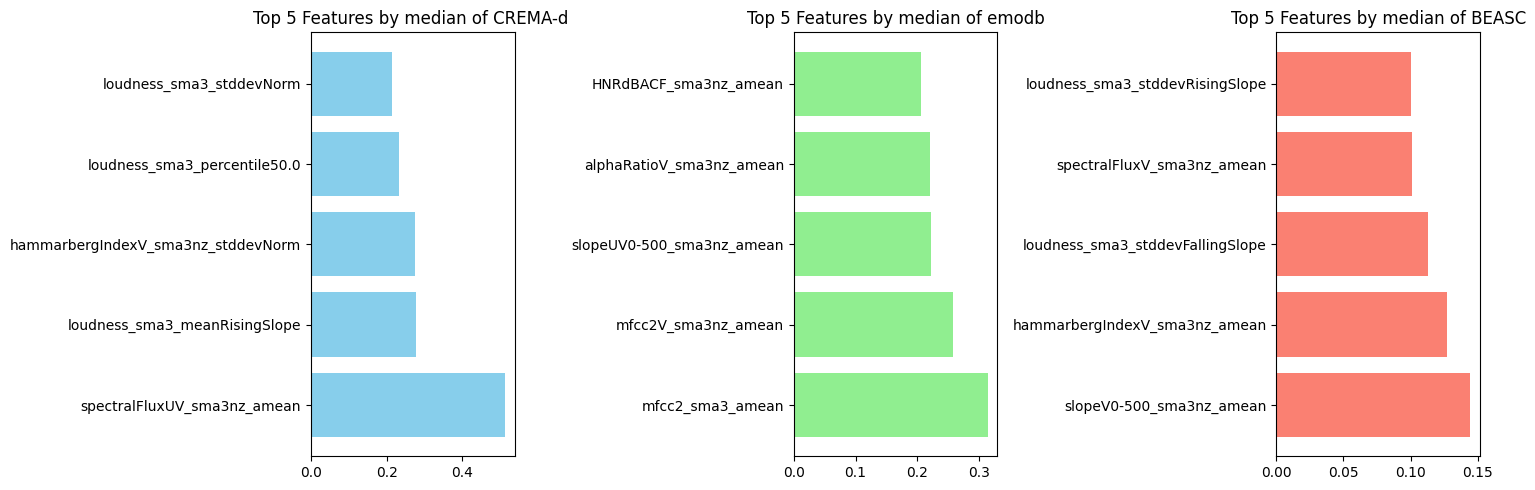

In [ ]:
plot_top_5_features(calculate_median_contributions(contributions_dict_crema_angry), calculate_median_contributions(contributions_dict_emodb_angry), calculate_median_contributions(contributions_dict_banglaser_angry))


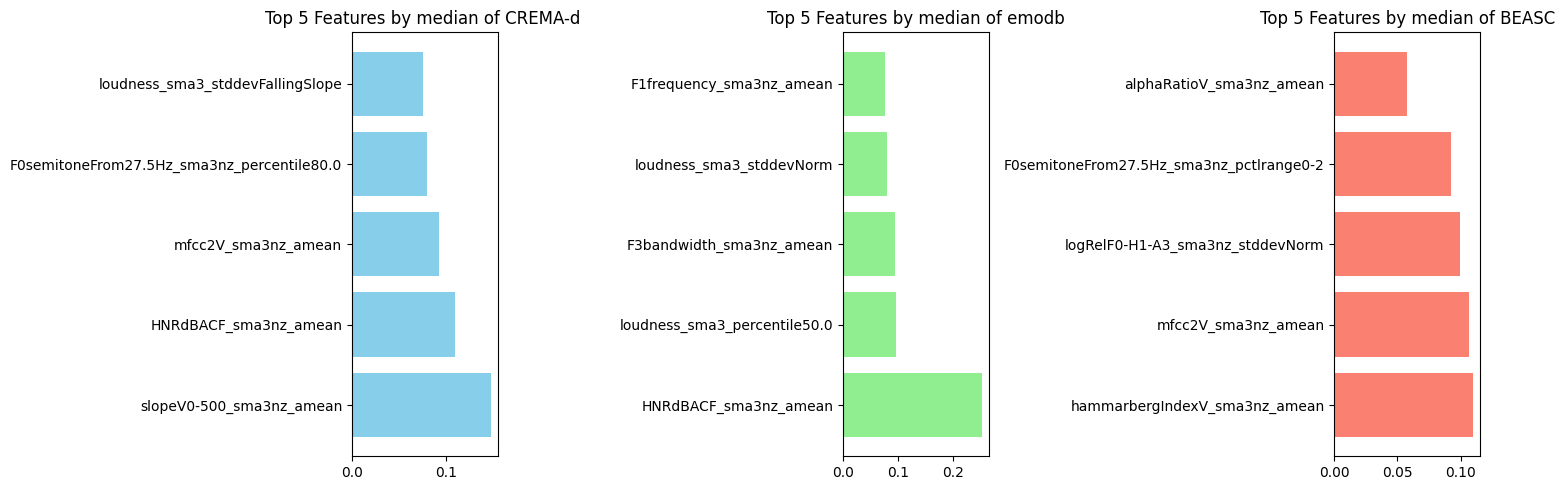

In [ ]:
plot_top_5_features(calculate_median_contributions(contributions_dict_crema_sad), calculate_median_contributions(contributions_dict_emodb_sad), calculate_median_contributions(contributions_dict_banglaser_sad))